## Preprocessing

In [1]:
# Imports here
import numpy as np
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Dataset here
file = open("../dataset/processed_reviews.json", 'r', encoding='utf8')
dataset_dict = json.load(file)
df_raw = pd.DataFrame(dataset_dict)

In [3]:
# Unused features
df = df_raw.copy(deep=True) #Do this so that I dont have to rerun the previous cell every time I make a change
df.drop(columns=['firm','job_title'], inplace=True) #one hotting these would create too many features

# Split up Date
df['date'] = pd.to_datetime(df['date_review'])
df['month'] = df['date'].dt.month.astype(str)
df['year'] = df['date'].dt.year

# Consider the length text inputs
df['pros_length'] = df['pros'].apply(lambda x: len(x))
df['cons_length'] = df['cons'].apply(lambda x: len(x))
df.drop(columns=['headline', 'pros', 'cons'], inplace=True)

# Encode 'current' as int
df['current'] = (df['current'] == 'Current Employee').astype(int)

# Min-max normalization
scaler = MinMaxScaler()
numeric_cols = df.select_dtypes(include=['int', 'float']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#One hot encode
one_hot_encoded = pd.get_dummies(df[['recommend', 'ceo_approv', 'outlook', 'month', 'duration']])
df = pd.concat([df, one_hot_encoded], axis=1)
df.drop(columns=['date', 'date_review', 'recommend', 'ceo_approv', 'outlook', 'month', 'duration'], inplace=True)

In [4]:
print(df.columns)
df.head()

Index(['current', 'overall_rating', 'work_life_balance', 'culture_values',
       'career_opp', 'comp_benefits', 'senior_mgmt', 'year', 'pros_length',
       'cons_length', 'recommend_o', 'recommend_v', 'recommend_x',
       'ceo_approv_o', 'ceo_approv_r', 'ceo_approv_v', 'ceo_approv_x',
       'outlook_o', 'outlook_r', 'outlook_v', 'outlook_x', 'month_1',
       'month_10', 'month_11', 'month_12', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'duration_less than 1 year', 'duration_more than 1 year',
       'duration_more than 10 years', 'duration_more than 3 years',
       'duration_more than 5 years', 'duration_more than 8 years',
       'duration_not mentioned'],
      dtype='object')


,current,overall_rating,work_life_balance,culture_values,career_opp,comp_benefits,senior_mgmt,year,pros_length,cons_length,...,month_7,month_8,month_9,duration_less than 1 year,duration_more than 1 year,duration_more than 10 years,duration_more than 3 years,duration_more than 5 years,duration_more than 8 years,duration_not mentioned
0,1.0,0.25,0.50,0.00,0.25,0.0,0.75,0.538462,0.002257,0.011246,...,False,False,False,False,True,False,False,False,False,False
1,1.0,0.00,0.00,0.00,0.00,0.0,0.00,0.615385,0.002753,0.020727,...,False,False,False,True,False,False,False,False,False,False
2,1.0,0.00,0.25,0.00,0.25,0.0,0.00,0.615385,0.001817,0.020541,...,False,False,False,False,True,False,False,False,False,False
3,1.0,0.50,0.75,0.25,0.25,0.5,0.25,0.615385,0.006607,0.009573,...,False,False,False,True,False,False,False,False,False,False
4,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.615385,0.005726,0.022493,...,False,False,True,False,False,False,False,False,False,True


In [5]:
#Spliting the data
X = df.drop(columns=['overall_rating'])
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (681651, 39) (681651,)
Testing set shape: (75740, 39) (75740,)


## Model Training

In [6]:
import tensorflow as tf

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [40]:
def buildReluNN():
    model = Sequential([
        Dense(32, activation = 'relu', input_dim = X.shape[1]),
        Dense(16, activation = 'relu'),
        Dense(8, activation = 'relu'),
        Dense(4, activation = 'relu'),
        Dense(1, activation = 'sigmoid'),
    ])
    optimizer = SGD(learning_rate=0.1)
    model.compile(optimizer=optimizer, loss='mse', metrics=['MSE'])
    return(model)

estimator = KerasRegressor(model=buildReluNN, epochs=100, batch_size=1000, verbose=1)
history = estimator.fit(X_train, y_train, validation_data=(X_test.astype('float'), y_test))
y_train_pred = estimator.predict(X_train)
y_test_pred = estimator.predict(X_test)
pd.DataFrame(y_test_pred)

Epoch 1/100
682/682 [==============================] - 1s 1ms/step - loss: 0.0625 - MSE: 0.0625 - val_loss: 0.0358 - val_MSE: 0.0358
Epoch 2/100
682/682 [==============================] - 1s 986us/step - loss: 0.0332 - MSE: 0.0332 - val_loss: 0.0320 - val_MSE: 0.0320
Epoch 3/100
682/682 [==============================] - 1s 912us/step - loss: 0.0312 - MSE: 0.0312 - val_loss: 0.0311 - val_MSE: 0.0311
Epoch 4/100
682/682 [==============================] - 1s 889us/step - loss: 0.0307 - MSE: 0.0307 - val_loss: 0.0308 - val_MSE: 0.0308
Epoch 5/100
682/682 [==============================] - 1s 894us/step - loss: 0.0305 - MSE: 0.0305 - val_loss: 0.0307 - val_MSE: 0.0307
Epoch 6/100
682/682 [==============================] - 1s 894us/step - loss: 0.0304 - MSE: 0.0304 - val_loss: 0.0306 - val_MSE: 0.0306
Epoch 7/100
682/682 [==============================] - 1s 897us/step - loss: 0.0303 - MSE: 0.0303 - val_loss: 0.0305 - val_MSE: 0.0305
Epoch 8/100
682/682 [==============================] - 1s

,0
0,0.219080
1,0.520309
2,0.679825
3,0.977790
4,0.304865
...,...
75735,0.705612
75736,0.952504
75737,0.948717
75738,0.977892


## Model Eval

In [9]:
MSE = sum((y_test_pred - y_test)**2)/y_test.size
print(MSE)

0.029163377991230626


In [10]:
# Fraction of Variance Unexplained
FVU = MSE/np.var(y_test)
print(FVU)

0.3375312127232222


In [38]:
y_test_pred_scaled = np.round((y_test_pred*4))
y_test_scaled = y_test*4
accuracy = (y_test_pred_scaled == y_test_scaled).sum()/len(y_test)
accuracy

0.5958146289939266

In [41]:
#Training MSE and FVU
MSE = sum((y_train_pred - y_train)**2)/y_train.size
print(MSE)

0.028879590993752053


In [42]:
FVU = MSE/np.var(y_train)
print(FVU)

0.3327577871770848


## Model Tuning

In [ ]:
import keras_tuner

In [ ]:
def buildHPmodel(hp):
  model= Sequential([
      Dense(32, activation = 'relu', input_dim = X.shape[1]),
      Dense(
              units=hp.Int("units", min_value=8, max_value=24, step=4),
              activation= 'relu',
      ),
      Dense(
              units=hp.Int("units", min_value=4, max_value=16, step=4),
              activation= 'relu',
      ),
      Dense(
              units=hp.Int("units", min_value=1, max_value=8, step=4),
              activation= 'relu',
      ),
      Dense(1, activation = 'sigmoid')
  ])

  optimizer = SGD(learning_rate=0.3)
  model.compile(optimizer=optimizer, loss='mse', metrics=['MSE'])
  return model

In [ ]:
hp = keras_tuner.HyperParameters()

tuner = keras_tuner.GridSearch(
    hypermodel=buildHPmodel,
    objective="val_loss",
    max_trials=10,
    seed=0,
    executions_per_trial=1,
    hyperparameters=hp,
    tune_new_entries=True,
    allow_new_entries=True,
    max_consecutive_failed_trials=3,
    overwrite=True
)

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test), verbose = 1)

Trial 9 Complete [00h 01m 21s]
val_loss: 0.02869807370007038

Best val_loss So Far: 0.02869807370007038
Total elapsed time: 00h 12m 06s


In [ ]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 08 summary
Hyperparameters:
units: 24
Score: 0.02869807370007038

Trial 03 summary
Hyperparameters:
units: 14
Score: 0.028774499893188477

Trial 07 summary
Hyperparameters:
units: 22
Score: 0.028802407905459404

Trial 00 summary
Hyperparameters:
units: 8
Score: 0.02884363941848278

Trial 01 summary
Hyperparameters:
units: 10
Score: 0.02884863130748272

Trial 04 summary
Hyperparameters:
units: 16
Score: 0.02886430360376835

Trial 05 summary
Hyperparameters:
units: 18
Score: 0.02886887826025486

Trial 02 summary
Hyperparameters:
units: 12
Score: 0.028917666524648666

Trial 06 summary
Hyperparameters:
units: 20
Score: 0.028966402634978294


## Hyperparameter Tuning - Random Search

In [ ]:
def HPmodel(hp):
    model = Sequential([
        Dense(hp.Int("units", min_value=32, max_value=64, step=2), activation = hp.Choice("activation", ["relu", "sigmoid", "softmax", "tanh"]), input_dim = X.shape[1]),
        Dense(hp.Int("units", min_value=32, max_value=256, step=8), activation = hp.Choice("activation", ["relu", "sigmoid", "softmax", "tanh"])),
        Dense(hp.Int("units", min_value=32, max_value=128, step=4), activation = hp.Choice("activation", ["relu", "sigmoid", "softmax", "tanh"])),
        Dense(hp.Int("units", min_value=32, max_value=64, step=4), activation = hp.Choice("activation", ["relu", "sigmoid", "softmax", "tanh"])),
        Dense(1, activation = 'sigmoid'),
    ])

    learning_rate = hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='log')
    optimizer = SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['MSE'])
    return(model)

In [ ]:
tuner = keras_tuner.RandomSearch(
    HPmodel,
    overwrite = True,
    objective='val_loss',
    max_trials = 20,
    max_consecutive_failed_trials=3
)
tuner.search(np.array(X_train).astype('float32'), y_train, epochs=5, validation_data=(np.array(X_test).astype('float32'), y_test))

### Model Eval

In [ ]:
model = tuner.get_best_models()[0]
print(model.summary())
y_pred = model.predict(np.array(X_test).astype('float32'))

In [ ]:
y_test_pred = y_pred.reshape(75740,)
MSE = sum((y_test_pred - y_test)**2)/y_test.size
print(MSE)

In [ ]:
FVU = MSE/np.var(y_test)
print(FVU)

## Graphs


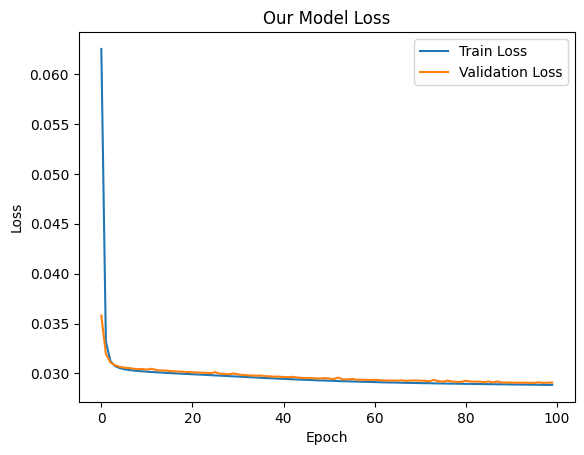

In [46]:
plt.plot(history.history_['loss'], label='Train Loss')
plt.plot(history.history_['val_loss'], label='Validation Loss')
plt.title(f'Our Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()